In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

# Подготовим данные

In [2]:
bank = pd.read_csv('bank/bank-full.csv', sep=';', decimal=",")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

bank['job'] = labelencoder.fit_transform(bank['job'])
bank['marital'] = labelencoder.fit_transform(bank['marital'])
bank['education'] = labelencoder.fit_transform(bank['education'])
bank['default'] = labelencoder.fit_transform(bank['default'])
bank['housing'] = labelencoder.fit_transform(bank['housing'])
bank['loan'] = labelencoder.fit_transform(bank['loan'])
bank['contact'] = labelencoder.fit_transform(bank['contact'])
bank['month'] = labelencoder.fit_transform(bank['month'])
bank['poutcome'] = labelencoder.fit_transform(bank['poutcome'])
bank['y'] = labelencoder.fit_transform(bank['y'])

bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [4]:
X = bank.iloc[:, :-1]
y = bank.iloc[:, 16]

In [5]:
# Разделим на обучающую и тестовую
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1234)  

# Строим XGBoost

In [6]:
!conda install -c anaconda py-xgboost -y

Solving environment: done

# All requested packages already installed.



In [7]:
from xgboost import XGBClassifier

In [8]:
from sklearn import metrics

Инициализируем модель

In [9]:
model = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3,
                      use_label_encoder=False)

Строим модель

In [10]:
model.fit(X_train, y_train)

[22:54:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [11]:
y_pred_train = model.predict(X_train)
print (metrics.classification_report(y_train, y_pred_train))

y_pred_test = model.predict(X_test)
print (metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     26744
           1       0.89      0.73      0.81      3547

    accuracy                           0.96     30291
   macro avg       0.93      0.86      0.89     30291
weighted avg       0.96      0.96      0.96     30291

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     13178
           1       0.63      0.48      0.54      1742

    accuracy                           0.91     14920
   macro avg       0.78      0.72      0.74     14920
weighted avg       0.90      0.91      0.90     14920



In [12]:
conf_mat = metrics.confusion_matrix(y_train, y_pred_train)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,26435,309
1,947,2600


In [13]:
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

,0,1
0,12681,497
1,912,830


Вывод: XGBoost ошибается меньше, чем модель градиентного бустинга, у которой было 337, 1053 (на обучающей) и 567, 2006 (на тестовой) ошибочных распознаваний нулевого и первого класса соответственно.

In [14]:
print("Accuracy on train set is ", metrics.accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", metrics.accuracy_score(y_test, y_pred_test)*100)

Accuracy on train set is  95.85355386088277
Accuracy on test set is  90.5563002680965


Визуализируем информативность переменных 

In [15]:
import seaborn as sns
sns.set(font_scale = 1.5)
import xgboost as xgb

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

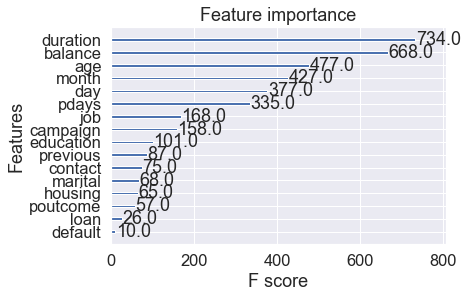

In [16]:
xgb.plot_importance(model, max_num_features = 16)

# Подбор гиперпараметров

In [72]:
from sklearn.model_selection import GridSearchCV

Строим сетку гиперпараметров

In [73]:
param_grid = {  
    'n_estimators': [100, 500, 800],
    'max_depth': [3, 5, 6]
}

Строим модель, параметры которые будем менять

In [93]:
model_2 = XGBClassifier(base_score=0.5, 
                        seed=1234, 
                        objective='binary:logistic',                         
                        learning_rate=0.1, 
                        silent=True,
                        use_label_encoder=False)

In [94]:
grid_search_res = GridSearchCV(model_2,
                               cv=5, 
                               error_score='raise',
                               param_grid = param_grid,
                               n_jobs=-1,
                               pre_dispatch='2*n_jobs', 
                               refit=True, 
                               scoring='accuracy', 
                               verbose=0)

In [95]:
grid_search_res.fit(X_train, y_train)

[13:10:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:10:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...traints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None,

Выведем результаты в красивой таблице

In [96]:
res = (
    pd.DataFrame({
        "mean_test_score": grid_search_res.cv_results_["mean_test_score"],
        "mean_fit_time": grid_search_res.cv_results_["mean_fit_time"]})
    .join(pd.json_normalize(grid_search_res.cv_results_["params"]).add_prefix("param_"))
)

print(res)

   mean_test_score  mean_fit_time  param_max_depth  param_n_estimators
0         0.901885       5.959178                3                 100
1         0.905120      29.841684                3                 500
2         0.905747      44.483418                3                 800
3         0.905682      10.472568                5                 100
4         0.905054      48.370907                5                 500
5         0.904856      76.302097                5                 800
6         0.905913      13.397149                6                 100
7         0.904724      59.234893                6                 500
8         0.905219      61.725544                6                 800


Лучшими параметрами оказались:

In [97]:
grid_search_res.best_params_

{'max_depth': 6, 'n_estimators': 100}

In [99]:
grid_search_res.best_score_

0.9059125106911999